In [58]:

import pandas as pd
import numpy as np
import pywt
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
%matplotlib inline


In [60]:
# Load USDPEN data
file_path_usdpen = "./PEN_data_only.csv"
try:
    usdpen_data = pd.read_csv(file_path_usdpen)
    usdpen_data['timestamp'] = pd.to_datetime(usdpen_data['timestamp'])  # Convert timestamp to datetime
    usdpen_data.sort_values(by='timestamp', inplace=True)  # Sort by timestamp
    usdpen_data.reset_index(drop=True, inplace=True)
    print("USDPEN Data loaded successfully!")

    # Filter only the USDPEN pair
    usdpen_data = usdpen_data[usdpen_data['pair'] == 'USDPEN']
    print(f"Filtered USDPEN data: {usdpen_data.shape}")

except Exception as e:
    print(f"Error loading USDPEN data: {e}")

# Load USDEUR data
file_path_usdeur = "./USDEUR_data.csv"
try:
    usdeur_data = pd.read_csv(file_path_usdeur)
    usdeur_data.rename(columns={
        'DateTime Stamp': 'timestamp',
        'Bar OPEN Bid Quote': 'open',
        'Bar HIGH Bid Quote': 'high',
        'Bar LOW Bid Quote': 'low',
        'Bar CLOSE Bid Quote': 'close',
        'Volume': 'volume'
    }, inplace=True)
    usdeur_data['timestamp'] = pd.to_datetime(usdeur_data['timestamp'], format='%Y%m%d %H%M%S')
    usdeur_data.sort_values(by='timestamp', inplace=True)  # Sort by timestamp
    usdeur_data.reset_index(drop=True, inplace=True)
    print("USDEUR Data loaded successfully!")
except Exception as e:
    print(f"Error loading USDEUR data: {e}")


USDPEN Data loaded successfully!
Filtered USDPEN data: (2610, 7)
USDEUR Data loaded successfully!


In [62]:
# Resample USDEUR to daily format
usdeur_data['date'] = usdeur_data['timestamp'].dt.date
usdeur_daily = usdeur_data.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum'
}).reset_index()
usdeur_daily.rename(columns={'date': 'timestamp'}, inplace=True)
print(f"Resampled USDEUR data to daily format: {usdeur_daily.shape}")


Resampled USDEUR data to daily format: (7264, 6)


In [64]:
# Function for wavelet denoising
def wavelet_denoising(series, wavelet='db4', level=3):
    coeffs = pywt.wavedec(series, wavelet, level=level)
    coeffs[-1] = np.zeros_like(coeffs[-1])  # Remove high-frequency noise
    coeffs[-2] = np.zeros_like(coeffs[-2])
    return pywt.waverec(coeffs, wavelet)[:len(series)]

# Apply denoising to specified columns
def apply_denoising(data, columns):
    for col in columns:
        data[f"{col}_denoised"] = wavelet_denoising(data[col].values)
    return data

# Apply denoising to USDPEN data
usdpen_denoised = apply_denoising(usdpen_data, ['close', 'high', 'low', 'open'])
print("Denoising applied to USDPEN data.")

# Apply denoising to USDEUR (resampled) data
usdeur_denoised = apply_denoising(usdeur_daily, ['close', 'high', 'low', 'open'])
print("Denoising applied to USDEUR data.")


Denoising applied to USDPEN data.
Denoising applied to USDEUR data.


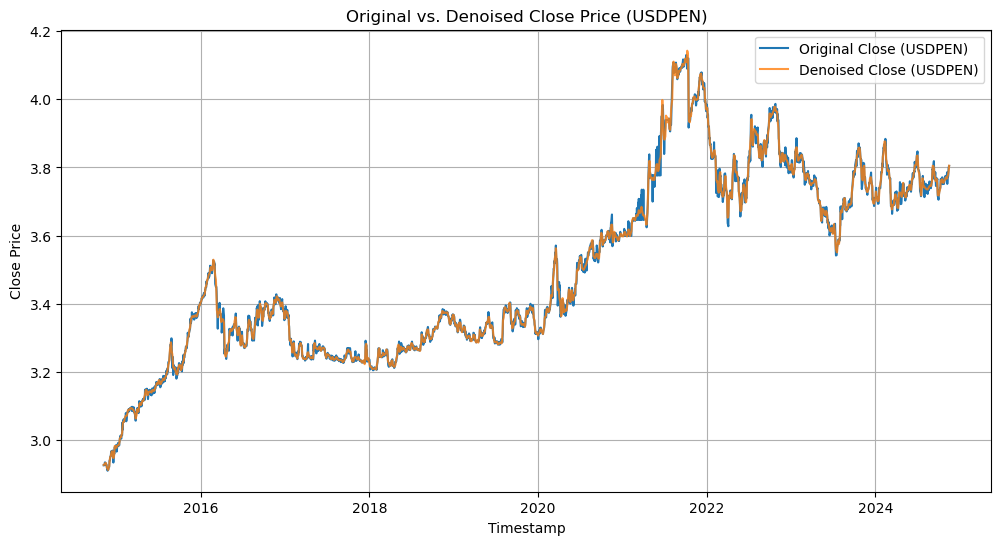

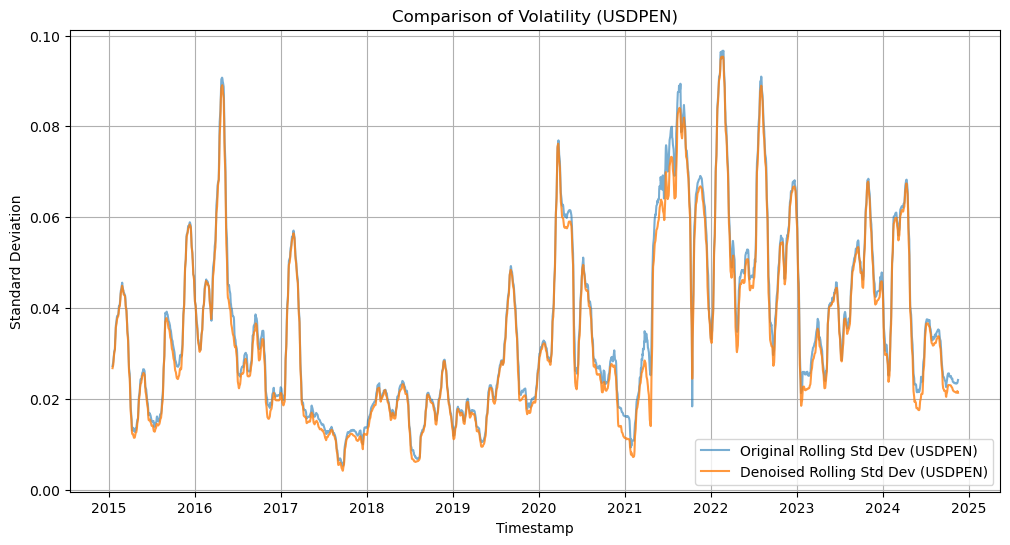

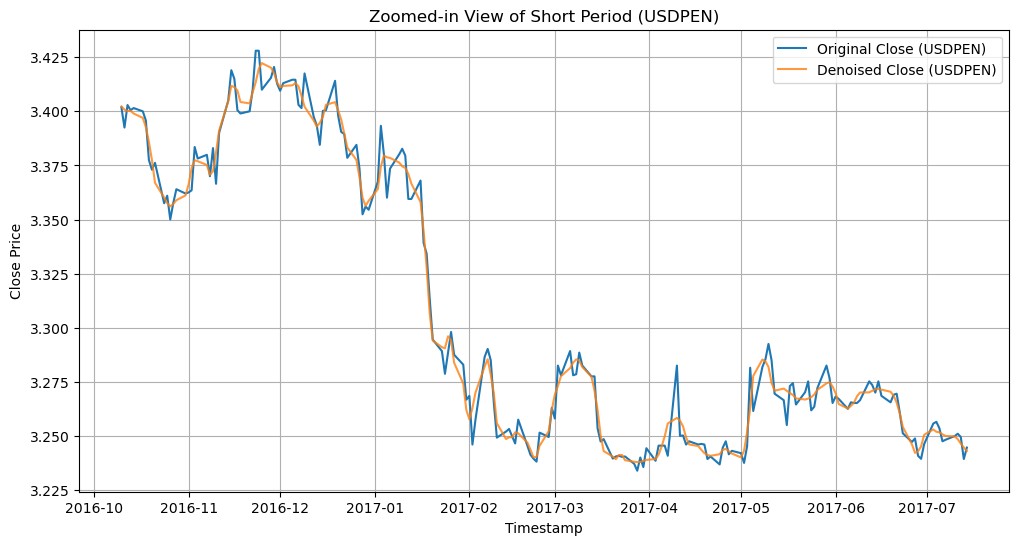

In [68]:
# Visualize original vs. denoised close prices for USDPEN
plt.figure(figsize=(12, 6))
plt.plot(usdpen_denoised['timestamp'], usdpen_denoised['close'], label="Original Close (USDPEN)")
plt.plot(usdpen_denoised['timestamp'], usdpen_denoised['close_denoised'], label="Denoised Close (USDPEN)", alpha=0.8)
plt.title("Original vs. Denoised Close Price (USDPEN)")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()


# Comparison of Volatility for USDPEN
plt.figure(figsize=(12, 6))
rolling_std_usdpen = usdpen_denoised['close'].rolling(window=50).std()
rolling_std_usdpen_denoised = usdpen_denoised['close_denoised'].rolling(window=50).std()
plt.plot(usdpen_denoised['timestamp'], rolling_std_usdpen, label="Original Rolling Std Dev (USDPEN)", alpha=0.6)
plt.plot(usdpen_denoised['timestamp'], rolling_std_usdpen_denoised, label="Denoised Rolling Std Dev (USDPEN)", alpha=0.8)
plt.title("Comparison of Volatility (USDPEN)")
plt.xlabel("Timestamp")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
zoom_start, zoom_end = 500, 700  
plt.plot(usdpen_denoised['timestamp'][zoom_start:zoom_end], usdpen_denoised['close'][zoom_start:zoom_end], label="Original Close (USDPEN)")
plt.plot(usdpen_denoised['timestamp'][zoom_start:zoom_end], usdpen_denoised['close_denoised'][zoom_start:zoom_end], label="Denoised Close (USDPEN)", alpha=0.8)
plt.title("Zoomed-in View of Short Period (USDPEN)")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()



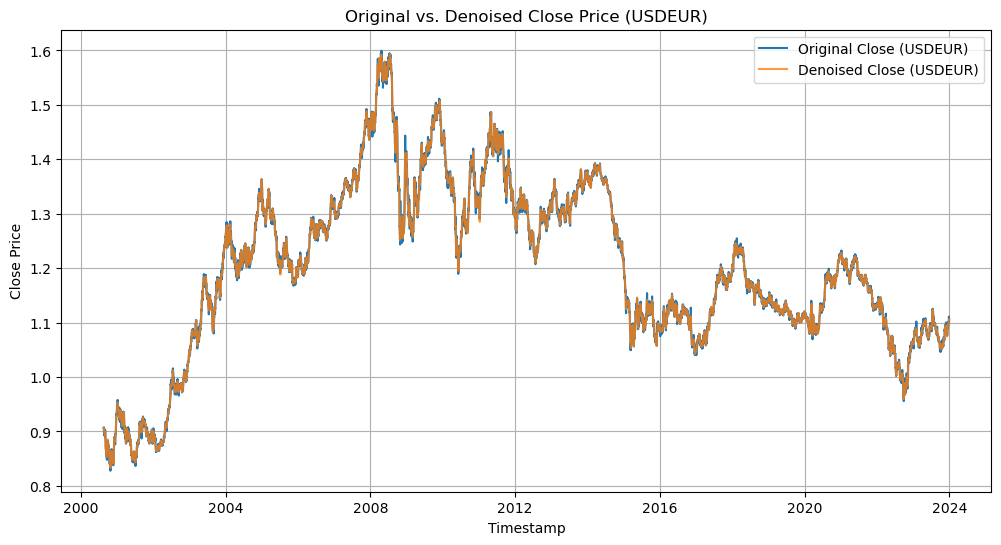

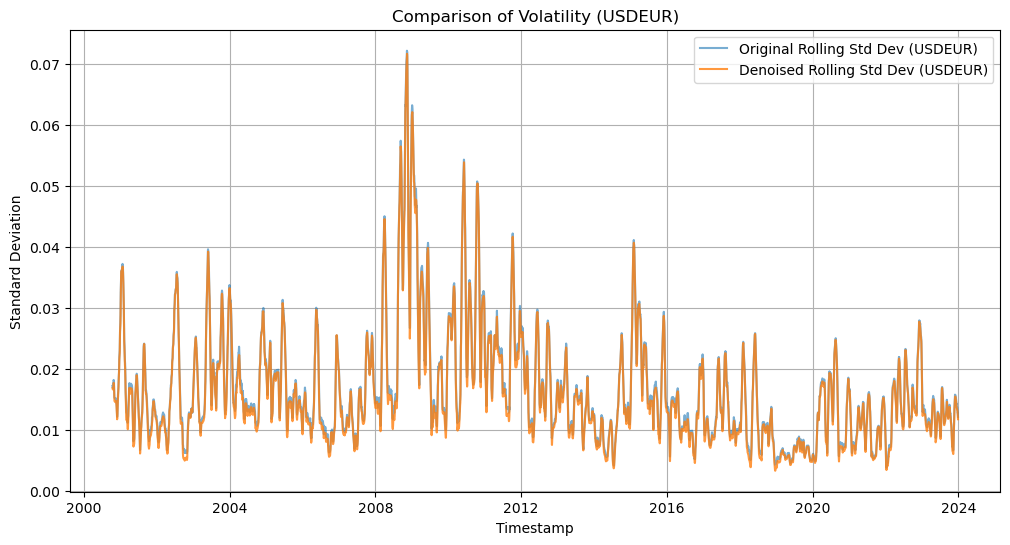

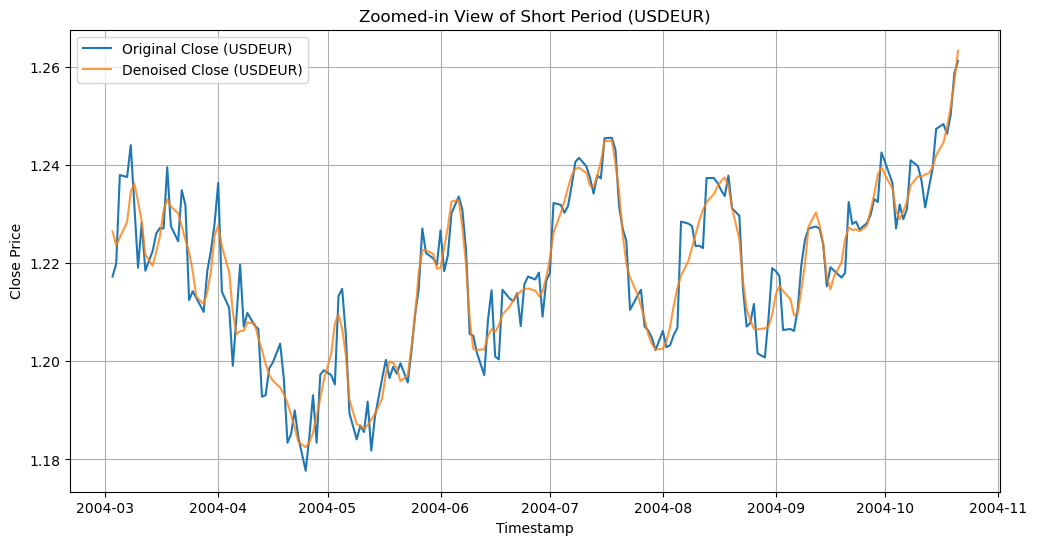

In [54]:

# Visualize original vs. denoised close prices for USDEUR
plt.figure(figsize=(12, 6))
plt.plot(usdeur_denoised['timestamp'], usdeur_denoised['close'], label="Original Close (USDEUR)")
plt.plot(usdeur_denoised['timestamp'], usdeur_denoised['close_denoised'], label="Denoised Close (USDEUR)", alpha=0.8)
plt.title("Original vs. Denoised Close Price (USDEUR)")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()


# Comparison of Volatility for USDEUR
plt.figure(figsize=(12, 6))
rolling_std_usdeur = usdeur_denoised['close'].rolling(window=50).std()
rolling_std_usdeur_denoised = usdeur_denoised['close_denoised'].rolling(window=50).std()
plt.plot(usdeur_denoised['timestamp'], rolling_std_usdeur, label="Original Rolling Std Dev (USDEUR)", alpha=0.6)
plt.plot(usdeur_denoised['timestamp'], rolling_std_usdeur_denoised, label="Denoised Rolling Std Dev (USDEUR)", alpha=0.8)
plt.title("Comparison of Volatility (USDEUR)")
plt.xlabel("Timestamp")
plt.ylabel("Standard Deviation")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
zoom_start, zoom_end = 1000, 1200  
plt.plot(usdeur_denoised['timestamp'][zoom_start:zoom_end], usdeur_denoised['close'][zoom_start:zoom_end], label="Original Close (USDEUR)")
plt.plot(usdeur_denoised['timestamp'][zoom_start:zoom_end], usdeur_denoised['close_denoised'][zoom_start:zoom_end], label="Denoised Close (USDEUR)", alpha=0.8)
plt.title("Zoomed-in View of Short Period (USDEUR)")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.show()


In [70]:
# Correlation analysis for USDPEN
correlation_usdpen = usdpen_denoised['close'].corr(usdpen_denoised['close_denoised'])
print(f"Correlation between Original and Denoised Close Prices (USDPEN): {correlation_usdpen:.4f}")

# Correlation analysis for USDEUR
correlation_usdeur = usdeur_denoised['close'].corr(usdeur_denoised['close_denoised'])
print(f"Correlation between Original and Denoised Close Prices (USDEUR): {correlation_usdeur:.4f}")

#Correlation value greater than 0.9 implies denoised data has strongly retained original trends and patterns


Correlation between Original and Denoised Close Prices (USDPEN): 0.9992
Correlation between Original and Denoised Close Prices (USDEUR): 0.9996


In [74]:
#  technical indicators
def add_indicators(data):
    # MACD
    data['MACD'] = data['close_denoised'].ewm(span=12).mean() - data['close_denoised'].ewm(span=26).mean()
    data['Signal_Line'] = data['MACD'].ewm(span=9).mean()

    # SMA
    sma_windows = [5, 10, 15, 20, 25, 30, 36]
    for window in sma_windows:
        data[f"SMA_{window}"] = data['close_denoised'].rolling(window=window).mean()

    # RSI
    rsi_windows = [5, 14, 20, 25]
    for window in rsi_windows:
        delta = data['close_denoised'].diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(window=window).mean()
        avg_loss = loss.rolling(window=window).mean()
        rs = avg_gain / avg_loss
        data[f"RSI_{window}"] = 100 - (100 / (1 + rs))

    # ADX
    adx_windows = [5, 10, 15, 20, 25, 30, 35]
    for window in adx_windows:
        tr = pd.concat([
            data['high_denoised'] - data['low_denoised'],
            (data['high_denoised'] - data['close_denoised'].shift()).abs(),
            (data['low_denoised'] - data['close_denoised'].shift()).abs()
        ], axis=1).max(axis=1)
        tr_sma = tr.rolling(window=window).mean()
        plus_dm = data['high_denoised'].diff()
        minus_dm = data['low_denoised'].diff()
        plus_dm[plus_dm < 0] = 0
        minus_dm[minus_dm > 0] = 0
        plus_di = 100 * (plus_dm.rolling(window=window).mean() / tr_sma)
        minus_di = 100 * (minus_dm.abs().rolling(window=window).mean() / tr_sma)
        dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di).abs()
        data[f"ADX_{window}"] = dx.rolling(window=window).mean()

    # Williams %R
    wr_windows = [5, 14, 20, 25]
    for window in wr_windows:
        highest_high = data['high_denoised'].rolling(window=window).max()
        lowest_low = data['low_denoised'].rolling(window=window).min()
        data[f"WR_{window}"] = -100 * (highest_high - data['close_denoised']) / (highest_high - lowest_low)

    # Bollinger Bands
    sma = data['close_denoised'].rolling(window=20).mean()
    std_dev = data['close_denoised'].rolling(window=20).std()
    data['Bollinger_Upper'] = sma + (2 * std_dev)
    data['Bollinger_Middle'] = sma
    data['Bollinger_Lower'] = sma - (2 * std_dev)

    return data

# Add indicators to USDPEN data
usdpen_with_indicators = add_indicators(usdpen_denoised)
print("Indicators added to USDPEN data.")

# Add indicators to USDEUR data
usdeur_with_indicators = add_indicators(usdeur_denoised)
print("Indicators added to USDEUR data.")


Indicators added to USDPEN data.
Indicators added to USDEUR data.


In [76]:

if 'pair' in usdpen_with_indicators.columns:
    usdpen_with_indicators.drop(columns=['pair'], inplace=True)
   
# Drop NaN values from USDPEN processed data
usdpen_with_indicators.dropna(inplace=True)
print(f"NaN values removed from USDPEN data. Remaining rows: {usdpen_with_indicators.shape[0]}")

# Drop NaN values from USDEUR processed data
usdeur_with_indicators.dropna(inplace=True)
print(f"NaN values removed from USDEUR data. Remaining rows: {usdeur_with_indicators.shape[0]}")

usdpen_with_indicators.to_csv("./Processed_USDPEN_data.csv", index=False)
print("Processed USDPEN data saved.")

usdeur_with_indicators.to_csv("./Processed_USDEUR_data.csv", index=False)
print("Processed USDEUR data saved.")


NaN values removed from USDPEN data. Remaining rows: 2541
NaN values removed from USDEUR data. Remaining rows: 7195
Processed USDPEN data saved.
Processed USDEUR data saved.
